## Initial Setup

In [1]:
import random
from random import uniform, choice
import matplotlib.pyplot as plt
import copy

In [2]:
# Constants
POPULATION_SIZE = 1000
NUM_GENERATIONS = 1000
MUTATION_RATE = 0.15
GRID_SIZE = 9
ELITE_SIZE = 5


In [3]:
base_grid = [
    [8, 0, 2, 0, 0, 3, 5, 1, 0],
    [0, 6, 0, 0, 9, 1, 0, 0, 3],
    [7, 0, 1, 0, 0, 0, 8, 9, 4],
    [6, 0, 8, 0, 0, 4, 0, 2, 1],
    [0, 0, 0, 2, 5, 8, 0, 6, 0],
    [9, 2, 0, 3, 1, 0, 4, 0, 0],
    [0, 0, 0, 4, 0, 2, 7, 8, 0],
    [0, 0, 5, 0, 8, 9, 0, 0, 0],
    [2, 0, 0, 0, 0, 7, 1, 0, 0]
]
#just an example

In [4]:
base_grid_hard = [
    [8, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 3, 6, 0, 0, 0, 0, 0],
    [0, 7, 0, 0, 9, 0, 2, 0, 0],
    [0, 5, 0, 0, 0, 7, 0, 0, 0],
    [0, 0, 0, 0, 4, 5, 7, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 3, 0],
    [0, 0, 1, 0, 0, 0, 0, 6, 8],
    [0, 0, 8, 5, 0, 0, 0, 1, 0],
    [0, 9, 0, 0, 0, 0, 4, 0, 0]
]
#just an example

## Utility Functions


### Print sudoku grid

In [5]:
def print_grid(grid):
    """Print the Sudoku grid in a human-readable format with 3x3 subgrid separators."""
    for i, row in enumerate(grid):
        if i % 3 == 0 and i != 0:
            print("-" * 21)
        for j, val in enumerate(row):
            if j % 3 == 0 and j != 0:
                print("| ", end="")
            print(str(val) if val != 0 else '.', end=" ")
        print()
    print()

In [6]:
print_grid(base_grid)

8 . 2 | . . 3 | 5 1 . 
. 6 . | . 9 1 | . . 3 
7 . 1 | . . . | 8 9 4 
---------------------
6 . 8 | . . 4 | . 2 1 
. . . | 2 5 8 | . 6 . 
9 2 . | 3 1 . | 4 . . 
---------------------
. . . | 4 . 2 | 7 8 . 
. . 5 | . 8 9 | . . . 
2 . . | . . 7 | 1 . . 



### Create an individual

In [7]:
def create_individual(base_grid):
    """Create a new individual Sudoku solution from the base grid."""
    individual = [row.copy() for row in base_grid]
    for row in range(GRID_SIZE):
        zeros = [k for k, v in enumerate(individual[row]) if v == 0]  # Identifying the empty positions
        numbers = list(set(range(1, 10)) - set(individual[row]))  # Determine the set of numbers in [1,9] missing from this row
        random.shuffle(numbers)
        for k in zeros:
            individual[row][k] = numbers.pop()  # Fill empty positions ('zeros') with the last number from 'numbers'
    return individual

### Define the fitness function

In [8]:
def calculate_fitness(individual):
    """Calculate the number of row, column, and subgrid conflicts."""
    conflicts = 0
    # Check rows and columns
    for i in range(GRID_SIZE):
        conflicts += (GRID_SIZE - len(set(individual[i])))  # Rows
        column = [individual[row][i] for row in range(GRID_SIZE)]
        conflicts += (GRID_SIZE - len(set(column)))  # Columns

    # Check 3x3 subgrids
    for i in range(0, GRID_SIZE, 3):
        for j in range(0, GRID_SIZE, 3):
            subgrid = []
            for k in range(3):
                subgrid.extend(individual[i + k][j:j + 3])
            conflicts += (GRID_SIZE - len(set(subgrid)))
    return conflicts

## Genetic Operators


### Selection
- Ranking selection

In [9]:
def selection(population, fitnesses, selection_size=None):
    """Select individuals based on their fitness scores."""
    if not selection_size:
        selection_size = len(population) // 2

    if selection_size <= 0:
        raise ValueError("Selection size must be greater than zero.")
    
    if selection_size > len(population):
        raise ValueError("Selection size cannot be greater than the population size.")

    # Sort population by fitness and select the best individuals
    sorted_population = sorted(zip(population, fitnesses), key=lambda x: x[1])  # Pair each individual with its corresponding fitness score, sort based on fitness value
    selected = [x[0] for x in sorted_population[:selection_size]]  # Individuals with lower scores come first in the sorted list

    # Ensure that the selection is not empty
    if len(selected) == 0:
        raise ValueError("Selection resulted in an empty list.")

    return selected

- Roulette Wheel selection (fitness proportionate)


Individuals with higher fitness values occupy larger "slices" of the roulette wheel, making them more likely to be selected.

In [10]:
# Fitness proportionate - roulette wheel Selection
def selection_fps(population):

    total_fitness = sum([1 / (calculate_fitness(i) + 1) for i in population])  # Inverse of fitness for minimization
    r = uniform(0, total_fitness)
    position = 0
    for individual in population:
        position += 1 / (calculate_fitness(individual) + 1) 
        if position > r:
            return individual


- Tournament Selection

In [11]:
def tournament_sel(population, tour_size=3):
    tournament = [choice(population) for _ in range(tour_size)]
    return min(tournament, key=calculate_fitness)

### Crossover function

In [12]:
def crossover(parent1, parent2):
    """Perform a single-point crossover by swapping rows."""
    point = random.randint(1, GRID_SIZE - 1)  # The point to determine the split of the grid for the swap between parents
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

### Mutation function

Dynamic Mutation Rate: Start with a higher mutation rate and reduce it over generations

In [13]:
def mutate(individual, base_grid, mutation_rate=0.05):
    """Mutate an individual by swapping two mutable cells in a row."""
    for row in range(GRID_SIZE):
        mutable_positions = [col for col in range(GRID_SIZE) if base_grid[row][col] == 0]
        if len(mutable_positions) > 1 and random.random() < mutation_rate: # checking if there are more than 2 mutable positions AND mutation rate
            pos1, pos2 = random.sample(mutable_positions, 2)
            individual[row][pos1], individual[row][pos2] = individual[row][pos2], individual[row][pos1]  # Swap values of row
    return individual

In [14]:
def dynamic_mutation_rate(generation, num_generations):
    """Adaptively adjust the mutation rate."""
    return max(0.01, MUTATION_RATE * (1 - (generation / num_generations)))

## Genetic Algorithm Function


Selection of the top-performing individuals

- Trial with tournament selection : slow and not the best solution
- Trial with fps (roulette wheel) selection : VERYYY slow and not the best solution

In [17]:
def solve_sudoku(base_grid, population_size=100, num_generations=1000, mutation_rate=0.05):
    """Solve a given Sudoku grid using a genetic algorithm."""
    fitness_history = [] ####
    # Initialize the population
    population = [create_individual(base_grid) for _ in range(population_size)]
    if len(population) == 0:
        raise ValueError("Initial population is empty. Check population initialization.")

    best_solution = None
    best_score = float('inf')

    for generation in range(num_generations):
        # Calculate fitness scores for all individuals
        fitnesses = [calculate_fitness(individual) for individual in population]
        if len(fitnesses) == 0:
            raise ValueError("Fitness list is empty. Check population initialization or mutation steps.")


        best_current_score = min(fitnesses)
        best_idx = fitnesses.index(best_current_score)

        if best_current_score < best_score:
            best_score = best_current_score
            best_solution = copy.deepcopy(population[best_idx])  # Make a deep copy of the best solution so it doesn't change through mutation


        fitness_history.append(best_score) ###

        print(f"Generation {generation}: Best Fitness = {best_score}")

        if best_score == 0:
            print("Optimal solution found!")
            break

        # Selection of the top-performing individuals
        selected = selection(population, fitnesses, selection_size=population_size)# // 2) ###################################################
        #selected = [tournament_sel(population) for _ in range(population_size)]    ### tournament ### : slow and not the best sol
        #selected = [selection_fps(population) for _ in range(population_size)]    ### fps ### : VERYYY slow and not the best sol
        if len(selected) == 0:
            raise ValueError("Selected population is empty. Check the selection function.")

        offspring = []

        # Handle odd number of selected parents
        if len(selected) % 2 != 0:
            offspring.append(selected[-1])

        # Generate the new population of offspirngs and then mutate them
        # Generate offspring through crossover
        for i in range(0, len(selected) - 1, 2):
            parent1, parent2 = selected[i], selected[i + 1]
            child1, child2 = crossover(parent1, parent2)
            offspring.extend([child1, child2])

        # Apply dynamic mutation to the offspring and form the next generation
        mutation_rate = dynamic_mutation_rate(generation, num_generations)
        population = [mutate(child, base_grid, mutation_rate) for child in offspring]  # P := P' 
        if len(population) == 0:
            raise ValueError("Population after mutation is empty. Check mutation steps.")


    # Display the best solution found
    if best_solution is not None:
        print("\nFinal Solution:")
        print_grid(best_solution)
    
    # Plot the fitness history
    plt.plot(fitness_history)
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness Score') # I want to have the mean of fitness scores
    plt.title('Fitness Score through Generations')
    plt.show()

#### Trial 1: Solving with selection of top-performing individuals AND ELITISM

*Gets stuck at local minimum*<br>


Generation 0: Best Fitness = 32
Generation 1: Best Fitness = 29
Generation 2: Best Fitness = 27
Generation 3: Best Fitness = 27
Generation 4: Best Fitness = 24
Generation 5: Best Fitness = 24
Generation 6: Best Fitness = 24
Generation 7: Best Fitness = 24
Generation 8: Best Fitness = 24
Generation 9: Best Fitness = 23
Generation 10: Best Fitness = 23
Generation 11: Best Fitness = 23
Generation 12: Best Fitness = 23
Generation 13: Best Fitness = 23
Generation 14: Best Fitness = 23
Generation 15: Best Fitness = 23
Generation 16: Best Fitness = 23
Generation 17: Best Fitness = 23
Generation 18: Best Fitness = 23
Generation 19: Best Fitness = 23
Generation 20: Best Fitness = 23
Generation 21: Best Fitness = 23
Generation 22: Best Fitness = 23
Generation 23: Best Fitness = 23
Generation 24: Best Fitness = 23
Generation 25: Best Fitness = 23
Generation 26: Best Fitness = 23
Generation 27: Best Fitness = 23
Generation 28: Best Fitness = 23
Generation 29: Best Fitness = 23
Generation 30: Best 

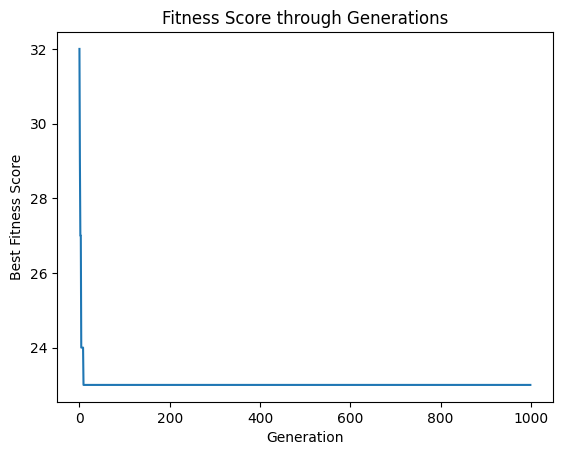

In [31]:
def solve_sudoku_t1(base_grid, population_size=100, num_generations=1000, mutation_rate=0.05,  elite_size=5):
    """Solve a given Sudoku grid using a genetic algorithm."""
    fitness_history = [] ####
    # Initialize the population
    population = [create_individual(base_grid) for _ in range(population_size)]
    if len(population) == 0:
        raise ValueError("Initial population is empty. Check population initialization.")

    best_solution = None
    best_score = float('inf')

    for generation in range(num_generations):
        # Calculate fitness scores for all individuals
        fitnesses = [calculate_fitness(individual) for individual in population]
        if len(fitnesses) == 0:
            raise ValueError("Fitness list is empty. Check population initialization or mutation steps.")
        
        best_current_score = min(fitnesses)
        best_idx = fitnesses.index(best_current_score)

        if best_current_score < best_score:
            best_score = best_current_score
            best_solution = copy.deepcopy(population[best_idx])  # Make a deep copy of the best solution so it doesn't change through mutation

        fitness_history.append(best_score) ###

        print(f"Generation {generation}: Best Fitness = {best_score}")

        if best_score == 0:
            print("Optimal solution found!")
            break

        # Select the top-performing individuals
        selected = selection(population, fitnesses, selection_size=population_size)
        #selected = [tournament_sel(population) for _ in range(population_size)]    ### tournament ### : slow and not the best sol
        #selected = [selection_fps(population) for _ in range(population_size)]    ### fps ### : VERYYY slow and not the best sol
        if len(selected) == 0:
            raise ValueError("Selected population is empty. Check the selection function.")

        offspring = []

        # Handle odd number of selected parents
        if len(selected) % 2 != 0:
            offspring.append(selected[-1])

        # Generate offspring through crossover
        for i in range(0, len(selected) - 1, 2):
            parent1, parent2 = selected[i], selected[i + 1]
            child1, child2 = crossover(parent1, parent2)
            offspring.extend([child1, child2])

        # Apply dynamic mutation to the offspring and form the next generation
        mutation_rate = dynamic_mutation_rate(generation, num_generations)
        population = [mutate(child, base_grid, mutation_rate) for child in offspring]
        if len(population) == 0:
            raise ValueError("Population after mutation is empty. Check mutation steps.")
        
        
        # Elitism: Preserve the best individuals
        sorted_pop = sorted(zip(population, fitnesses), key=lambda x: x[1])  # The first individuals in the list have the best fitnesses, aka min
        elites = [x[0] for x in sorted_pop[:elite_size]]  # Extract the 5 best individuals
        # Replace the first worst individuals with the elites
        for elite in elites:
            worst = max(population, key=calculate_fitness)
            if calculate_fitness(elite) < calculate_fitness(worst):
                population.pop(population.index(worst))
                population.append(elite)


    # Display the best solution found
    if best_solution is not None:
        print("\nFinal Solution:")
        print_grid(best_solution)
    
    # Plot the fitness history
    plt.plot(fitness_history)
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness Score') # I want to have the mean of fitness scores
    plt.title('Fitness Score through Generations')
    plt.show()

solve_sudoku_t1(base_grid, POPULATION_SIZE, 1000, 0.15, 10)

#### Trial 2: Select the best individuals of a mixed population of parents+children

Implementation of code: the algorithm keeps parents if fitness is better than children

_Gets stuck at local minima_ = lose diversity

Generation 0: Best Fitness = 32
Generation 1: Best Fitness = 30
Generation 2: Best Fitness = 29
Generation 3: Best Fitness = 29
Generation 4: Best Fitness = 26
Generation 5: Best Fitness = 26
Generation 6: Best Fitness = 26
Generation 7: Best Fitness = 26
Generation 8: Best Fitness = 26
Generation 9: Best Fitness = 26
Generation 10: Best Fitness = 26
Generation 11: Best Fitness = 26
Generation 12: Best Fitness = 26
Generation 13: Best Fitness = 26
Generation 14: Best Fitness = 26
Generation 15: Best Fitness = 26
Generation 16: Best Fitness = 26
Generation 17: Best Fitness = 26
Generation 18: Best Fitness = 26
Generation 19: Best Fitness = 26
Generation 20: Best Fitness = 26
Generation 21: Best Fitness = 26
Generation 22: Best Fitness = 26
Generation 23: Best Fitness = 26
Generation 24: Best Fitness = 26
Generation 25: Best Fitness = 26
Generation 26: Best Fitness = 26
Generation 27: Best Fitness = 26
Generation 28: Best Fitness = 26
Generation 29: Best Fitness = 26
Generation 30: Best 

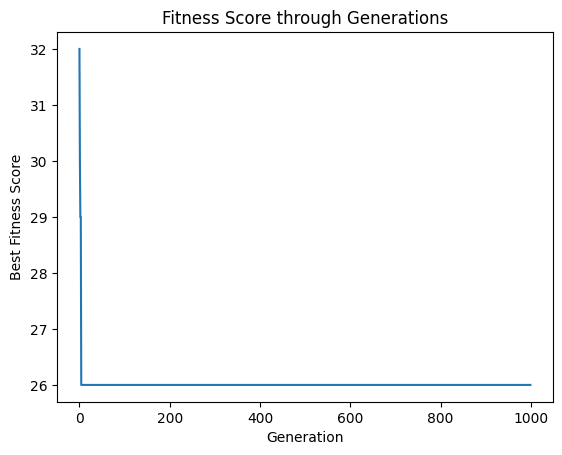

In [18]:
def solve_sudoku_t2(base_grid, population_size=100, num_generations=1000, mutation_rate=0.05):
    """Solve a given Sudoku grid using a genetic algorithm."""
    fitness_history = [] ####
    # Initialize the population
    population = [create_individual(base_grid) for _ in range(population_size)]
    if len(population) == 0:
        raise ValueError("Initial population is empty. Check population initialization.")

    best_solution = None
    best_score = float('inf')

    for generation in range(num_generations):
        # Calculate fitness scores for all individuals
        fitnesses = [calculate_fitness(individual) for individual in population]
        if len(fitnesses) == 0:
            raise ValueError("Fitness list is empty. Check population initialization or mutation steps.")
        
        best_current_score = min(fitnesses)  # Elitism
        best_idx = fitnesses.index(best_current_score)

        if best_current_score < best_score:
            best_score = best_current_score
            best_solution = copy.deepcopy(population[best_idx])  # Make a deep copy of the best solution so it doesn't change through mutation

        fitness_history.append(best_score) ###

        print(f"Generation {generation}: Best Fitness = {best_score}")

        if best_score == 0:
            print("Optimal solution found!")
            break

        # Select the top-performing individuals
        selected = selection(population, fitnesses, selection_size=population_size)
        #selected = [tournament_sel(population) for _ in range(population_size)]    ### tournament ### : slow and not the best sol
        #selected = [selection_fps(population) for _ in range(population_size)]    ### fps ### : VERYYY slow and not the best sol
        if len(selected) == 0:
            raise ValueError("Selected population is empty. Check the selection function.")

        offspring = []

        # Handle odd number of selected parents
        if len(selected) % 2 != 0:
            offspring.append(selected[-1])

        # Generate offspring through crossover
        for i in range(0, len(selected) - 1, 2):
            parent1, parent2 = selected[i], selected[i + 1]
            child1, child2 = crossover(parent1, parent2)
            offspring.extend([child1, child2])

        # Apply dynamic mutation to the offspring and form the next generation
        mutation_rate = dynamic_mutation_rate(generation, num_generations)
        population = [mutate(child, base_grid, mutation_rate) for child in offspring]
        if len(population) == 0:
            raise ValueError("Population after mutation is empty. Check mutation steps.")
        


        # Combine parents and children
        combined_population = population + offspring
        combined_fitnesses = [calculate_fitness(individual) for individual in combined_population]

        # Select the best individuals from the combined population
        population = selection(combined_population, combined_fitnesses, selection_size=population_size)



    # Display the best solution found
    if best_solution is not None:
        print("\nFinal Solution:")
        print_grid(best_solution)
    
    # Plot the fitness history
    plt.plot(fitness_history)
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness Score') # I want to have the mean of fitness scores
    plt.title('Fitness Score through Generations')
    plt.show()

solve_sudoku_t2(base_grid, POPULATION_SIZE, 1000, 0.15)

#### Trial 3: Restart strategy population

Reinitializes the population at certain moments (when reaches the restart_interval in generations) through generations to introduce new genetic material and help escape local minima.
_does not show significant change in results_

In [19]:
# Restart strategy with 'initialize_population' function
def solve_sudoku_t3(base_grid, population_size=100, num_generations=1000, mutation_rate=0.05, restart_interval=200):
    """Solve a given Sudoku grid using a genetic algorithm."""
    population = [create_individual(base_grid) for _ in range(population_size)]

    def initialize_population():
        return [create_individual(base_grid) for _ in range(population_size)]

    best_solution = None
    best_score = float('inf')

    # Restarting population
    for generation in range(num_generations):
        if generation % restart_interval == 0:
            print(f"Restarting population at generation {generation}")
            population = initialize_population()

        fitnesses = [calculate_fitness(individual) for individual in population]

        best_current_score = min(fitnesses)
        best_idx = fitnesses.index(best_current_score)

        if best_current_score < best_score:
            best_score = best_current_score
            best_solution = copy.deepcopy(population[best_idx])  # Make a deep copy of the best solution so it doesn't change through mutation

        print(f"Generation {generation}: Best Fitness = {best_score}")

        if best_score == 0:
            print("Optimal solution found!")
            break

        selected = selection(population, fitnesses, selection_size=population_size)
        offspring = []
        if len(selected) % 2 != 0:
            offspring.append(selected[-1])
        for i in range(0, len(selected) - 1, 2):
            parent1, parent2 = selected[i], selected[i + 1]
            child1, child2 = crossover(parent1, parent2)
            offspring.extend([child1, child2])

        mutation_rate = dynamic_mutation_rate(generation, num_generations)
        population = [mutate(child, base_grid, mutation_rate) for child in offspring]

    if best_solution is not None:
        print("\nFinal Solution:")
        print_grid(best_solution)


solve_sudoku_t3(base_grid, POPULATION_SIZE, 1000, 0.15, 200)

Restarting population at generation 0
Generation 0: Best Fitness = 33
Generation 1: Best Fitness = 27
Generation 2: Best Fitness = 27
Generation 3: Best Fitness = 27
Generation 4: Best Fitness = 27
Generation 5: Best Fitness = 27
Generation 6: Best Fitness = 27
Generation 7: Best Fitness = 25
Generation 8: Best Fitness = 23
Generation 9: Best Fitness = 23
Generation 10: Best Fitness = 22
Generation 11: Best Fitness = 22
Generation 12: Best Fitness = 22
Generation 13: Best Fitness = 22
Generation 14: Best Fitness = 22
Generation 15: Best Fitness = 22
Generation 16: Best Fitness = 22
Generation 17: Best Fitness = 22
Generation 18: Best Fitness = 22
Generation 19: Best Fitness = 20
Generation 20: Best Fitness = 20
Generation 21: Best Fitness = 20
Generation 22: Best Fitness = 20
Generation 23: Best Fitness = 20
Generation 24: Best Fitness = 20
Generation 25: Best Fitness = 20
Generation 26: Best Fitness = 20
Generation 27: Best Fitness = 20
Generation 28: Best Fitness = 20
Generation 29: 

## Execution

Generation 0: Best Fitness = 27
Generation 1: Best Fitness = 26
Generation 2: Best Fitness = 25
Generation 3: Best Fitness = 24
Generation 4: Best Fitness = 24
Generation 5: Best Fitness = 23
Generation 6: Best Fitness = 21
Generation 7: Best Fitness = 21
Generation 8: Best Fitness = 20
Generation 9: Best Fitness = 20
Generation 10: Best Fitness = 19
Generation 11: Best Fitness = 19
Generation 12: Best Fitness = 19
Generation 13: Best Fitness = 19
Generation 14: Best Fitness = 19
Generation 15: Best Fitness = 19
Generation 16: Best Fitness = 19
Generation 17: Best Fitness = 19
Generation 18: Best Fitness = 19
Generation 19: Best Fitness = 19
Generation 20: Best Fitness = 19
Generation 21: Best Fitness = 19
Generation 22: Best Fitness = 19
Generation 23: Best Fitness = 19
Generation 24: Best Fitness = 19
Generation 25: Best Fitness = 18
Generation 26: Best Fitness = 18
Generation 27: Best Fitness = 18
Generation 28: Best Fitness = 18
Generation 29: Best Fitness = 18
Generation 30: Best 

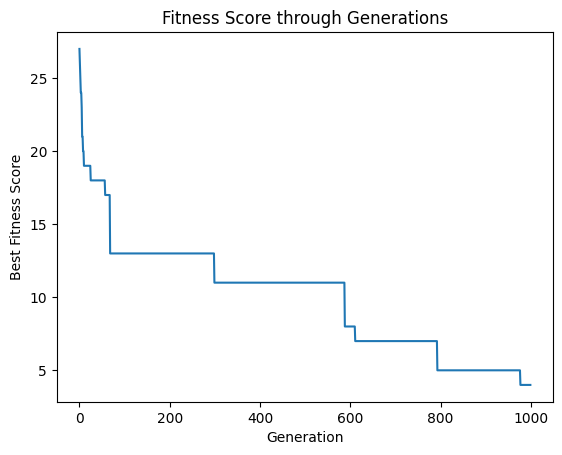

In [18]:
solve_sudoku(base_grid, POPULATION_SIZE, NUM_GENERATIONS, MUTATION_RATE)